In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 120
n_head = 6
n_layer = 5
dropout = 0.2
# ------------

# check if using gpu
if (device == 'cuda'):
    print("Using GPU")
else:
    print("Using CPU")

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# datasets, uncomment desired file_name line below
file_name = 'input_childSpeech_trainingSet.txt'
#file_name = 'input_childSpeech_testSet.txt'
#file_name = 'input_shakespeare.txt'
with open(file_name, 'r', encoding='utf-8') as f:
    text = f.read()

# dataset size, its vocab of characters and its vocab size
dataset_size = len(text)
chars = sorted(list(set(text)))
vocab_size = len(chars)

# print some info about the dataset
print("-----------------")
print(f"file: {file_name}")
print(f"chars: {chars}")
print(f"dataset_size: {dataset_size}")
print(f"vocab_size: {vocab_size}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# instantiate GPT model and print num params
model = GPTLanguageModel()
m = model.to(device)

# print the number of parameters in the model
num_params = sum(p.numel() for p in m.parameters()) / 1e6
print(f"num_params: {num_params} million")
print("-----------------")
print("Training...")

# create a PyTorch optimizer (AdamW variant of Adam optimizer chosen for better weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training and validation losses at each interval
train_losses = []
validation_losses = []
generalization_gaps = []

print(f"step, training loss, validation loss, generalization gap")
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        # modifying to make easy for LaTeX table populating
        print(f"{iter} & {losses['train']:.4f} & {losses['val']:.4f} & {losses['val'] - losses['train']:.4f} \\\\")
        train_losses.append(losses['train'])
        validation_losses.append(losses['val'])
        generalization_gaps.append(losses['val'] - losses['train'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))
print("-----------------")

# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, max_iters + 1, eval_interval), train_losses, label='Training Loss', color='blue')
plt.plot(range(0, max_iters + 1, eval_interval), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\micha\miniconda3\envs\tf-gpu\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

Evaluating test set
-----------------
file: input_shakespeare.txt
chars: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
dataset_size: 1115394
vocab_size: 65
Test loss: 7.8794


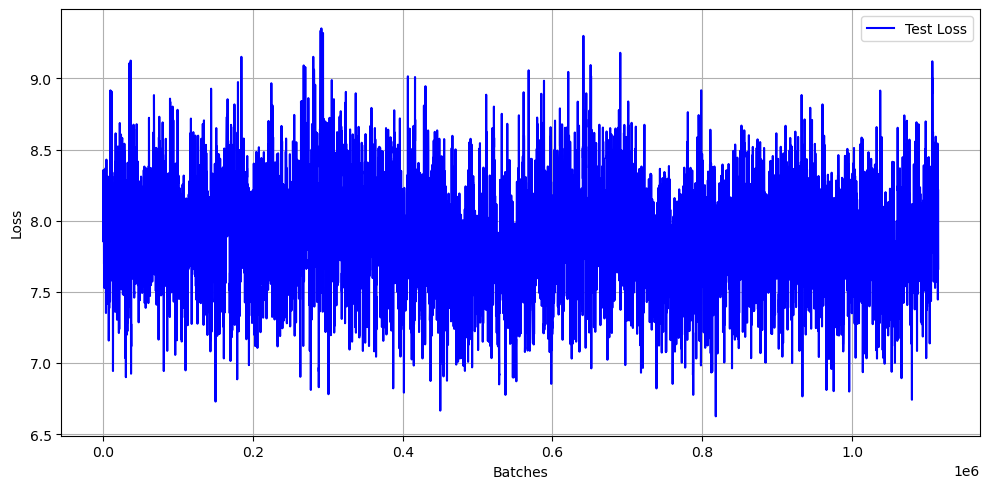

In [58]:
import random
print("Evaluating test set")

# test datasets
#test_file_name = 'input_childSpeech_testSet.txt'
test_file_name = 'input_shakespeare.txt'
with open(test_file_name, 'r', encoding='utf-8') as f:
    test_text = f.read()

# dataset size, its vocab of characters and its vocab size
test_set_size = len(test_text)
test_chars = sorted(list(set(test_text)))
test_vocab_size = len(test_chars)

# print some info about the dataset
print("-----------------")
print(f"file: {test_file_name}")
print(f"chars: {test_chars}")
print(f"dataset_size: {test_set_size}")
print(f"vocab_size: {test_vocab_size}")

# create a mapping from characters to integers
encode = lambda s: [stoi[c] if c in stoi else stoi[' '] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# test data
test_data = torch.tensor(encode(test_text), dtype=torch.long)

@torch.no_grad()
def estimate_loss_test(test_data):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_batches = 0
    losses = []
    batch_indices = []

    # test data blocks
    for k in range(0, len(test_data) - block_size, batch_size):
        # within bounds
        end_idx = min(k + batch_size, len(test_data) - block_size)
        batch_size_actual = end_idx - k

        x = torch.stack([test_data[j:j + block_size] for j in range(k, end_idx)])
        y = torch.stack([test_data[j + 1:j + block_size + 1] for j in range(k, end_idx)])
        x, y = x.to(device), y.to(device)

        # logits and loss
        logits, loss = model(x, y)
        total_loss += loss.item() * batch_size_actual
        total_batches += batch_size_actual
        losses.append(loss.cpu().numpy())
        batch_indices.append(k)

    # average loss, losses, and batches
    return (total_loss / total_batches), losses, batch_indices

# test set
avg_test_loss, test_losses, test_batches = estimate_loss_test(test_data=test_data)
print(f"Test loss: {avg_test_loss:.4f}")

# plot
plt.figure(figsize=(10, 5))
plt.plot(test_batches, test_losses, label='Test Loss', color='blue')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('best_model_test_loss.png')
plt.show()

Using GPU
-----------------
file: input_childSpeech_trainingSet.txt
chars: ['\n', ' ', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'L', 'M', 'N', 'R', 'S', 'U', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
dataset_size: 246982
vocab_size: 40
num_params: 0.9106 million
-----------------
Training...
step, training loss, validation loss, generalization gap
0 & 3.7097 & 3.7085 & -0.0012 \\
500 & 3.1221 & 3.1142 & -0.0079 \\
1000 & 3.1204 & 3.1164 & -0.0040 \\
1500 & 3.1142 & 3.1205 & 0.0063 \\
2000 & 3.0817 & 3.1348 & 0.0531 \\
2500 & 3.0028 & 3.1726 & 0.1698 \\
3000 & 2.8787 & 3.2321 & 0.3534 \\
3500 & 2.7579 & 3.2950 & 0.5371 \\
4000 & 2.6474 & 3.3578 & 0.7104 \\
4500 & 2.5481 & 3.4209 & 0.8728 \\
4999 & 2.4774 & 3.4457 & 0.9683 \\

fhsMr hdweuImsI
eI
Dtgki oMhN
wesdtN ed  h  eoW ar    LWaeik a
jeygddm
mWdetmaor Ngutgcibtos Nstdihilwsgtoaiea nwlbe
h Y sueo t laphie ay td olleehBijkhfaiele
 to as
ihkprhhbtj
leteIreDetd

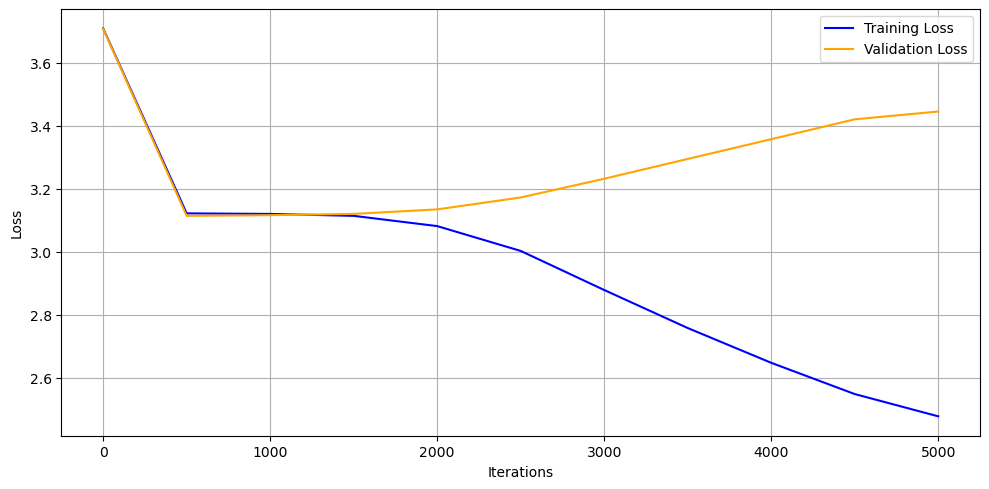

Evaluating dummy performance
Dummy test loss: 9.8154


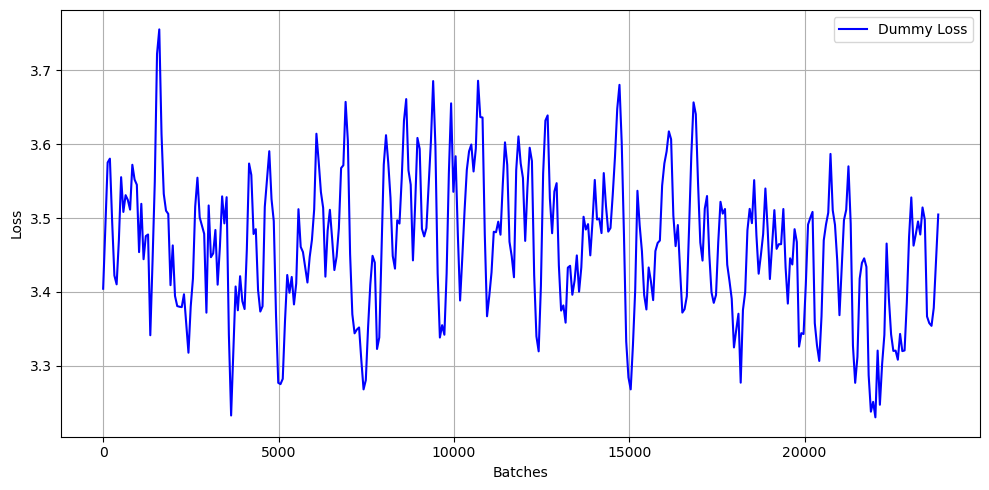

In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 120
n_head = 6
n_layer = 5
dropout = 0.2
# ------------

# check if using gpu
if (device == 'cuda'):
    print("Using GPU")
else:
    print("Using CPU")

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# datasets, uncomment desired file_name line below
file_name = 'input_childSpeech_trainingSet.txt'
#file_name = 'input_childSpeech_testSet.txt'
#file_name = 'input_shakespeare.txt'
with open(file_name, 'r', encoding='utf-8') as f:
    text = f.read()
    text = ''.join(random.sample(text, len(text)))

# dataset size, its vocab of characters and its vocab size
dataset_size = len(text)
chars = sorted(list(set(text)))
vocab_size = len(chars)

# print some info about the dataset
print("-----------------")
print(f"file: {file_name}")
print(f"chars: {chars}")
print(f"dataset_size: {dataset_size}")
print(f"vocab_size: {vocab_size}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# instantiate GPT model and print num params
model = GPTLanguageModel()
m = model.to(device)

# print the number of parameters in the model
num_params = sum(p.numel() for p in m.parameters()) / 1e6
print(f"num_params: {num_params} million")
print("-----------------")
print("Training...")

# create a PyTorch optimizer (AdamW variant of Adam optimizer chosen for better weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training and validation losses at each interval
train_losses = []
validation_losses = []
generalization_gaps = []

print(f"step, training loss, validation loss, generalization gap")
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        # modifying to make easy for LaTeX table populating
        print(f"{iter} & {losses['train']:.4f} & {losses['val']:.4f} & {losses['val'] - losses['train']:.4f} \\\\")
        train_losses.append(losses['train'])
        validation_losses.append(losses['val'])
        generalization_gaps.append(losses['val'] - losses['train'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))
print("-----------------")

# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, max_iters + 1, eval_interval), train_losses, label='Training Loss', color='blue')
plt.plot(range(0, max_iters + 1, eval_interval), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluating test set
-----------------
file: input_shakespeare.txt
chars: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
dataset_size: 1115394
vocab_size: 65
Test loss: 3.4090


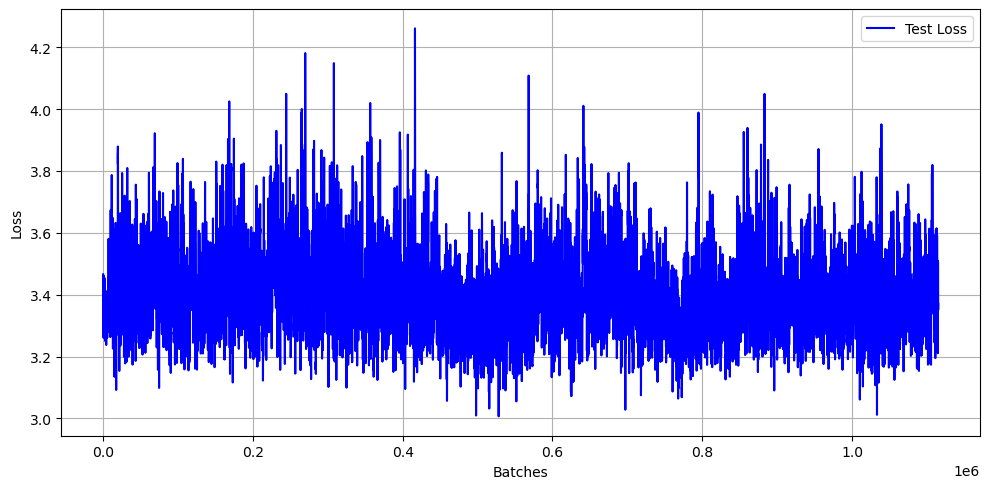

In [60]:
dummy_m = False
if dummy_m:
    dummy_model = model

import random
print("Evaluating test set")

# test datasets
#test_file_name = 'input_childSpeech_testSet.txt'
test_file_name = 'input_shakespeare.txt'
with open(test_file_name, 'r', encoding='utf-8') as f:
    test_text = f.read()

# dataset size, its vocab of characters and its vocab size
test_set_size = len(test_text)
test_chars = sorted(list(set(test_text)))
test_vocab_size = len(test_chars)

# print some info about the dataset
print("-----------------")
print(f"file: {test_file_name}")
print(f"chars: {test_chars}")
print(f"dataset_size: {test_set_size}")
print(f"vocab_size: {test_vocab_size}")

# test data
test_data = torch.tensor(encode(test_text), dtype=torch.long)

@torch.no_grad()
def estimate_loss_test(test_data):
    dummy_model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_batches = 0
    losses = []
    batch_indices = []

    # test data blocks
    for k in range(0, len(test_data) - block_size, batch_size):
        # within bounds
        end_idx = min(k + batch_size, len(test_data) - block_size)
        batch_size_actual = end_idx - k

        x = torch.stack([test_data[j:j + block_size] for j in range(k, end_idx)])
        y = torch.stack([test_data[j + 1:j + block_size + 1] for j in range(k, end_idx)])
        x, y = x.to(device), y.to(device)

        # logits and loss
        logits, loss = dummy_model(x, y)
        total_loss += loss.item() * batch_size_actual
        total_batches += batch_size_actual
        losses.append(loss.cpu().numpy())
        batch_indices.append(k)

    # average loss, losses, and batches
    return (total_loss / total_batches), losses, batch_indices

# test set
avg_test_loss, test_losses, test_batches = estimate_loss_test(test_data=test_data)
print(f"Test loss: {avg_test_loss:.4f}")

# plot
plt.figure(figsize=(10, 5))
plt.plot(test_batches, test_losses, label='Test Loss', color='blue')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dummy_loss_shake.png')
plt.show()